In [1]:
%load_ext autoreload
%autoreload 2
from skimage import data
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread, imwrite
from scipy import ndimage
import helperfunctions as hf

Here I compare linear blending and mean-intensity blending to hide the seam between overlapping images in stitched image.

TLDR: Linear blending seems like an improvement over the mean projection; the seam and registration errors are both slightly less obvious. However, it's a lot more work to implement, and it's not clear that the improvement is worth the extra effort.

These images were manually extracted from the skimage.data.cells3d() dataset. They were upscaled by a factor of 8 w/ bicubic interpolation, converted to 8bit, and noise was artificially added 6X in FIJI with the Process > Noise > Add Noise command.

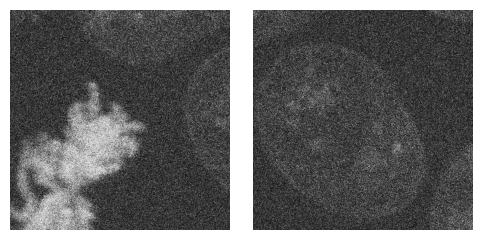

In [2]:
left = imread('images/upscaled/left_up_noise6.tif')
right = imread('images/upscaled/right_up_noise6.tif')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5))
ax1.imshow(left, cmap='gray'); ax1.axis('off'); ax2.imshow(right, cmap='gray'); ax2.axis('off')
fig.tight_layout(); plt.show()

Simple max projection of the two images leaves a clear seam marking the overlap. This is because the noise is randomly distributed, and subsequently becomes more dense in the overlapping region.

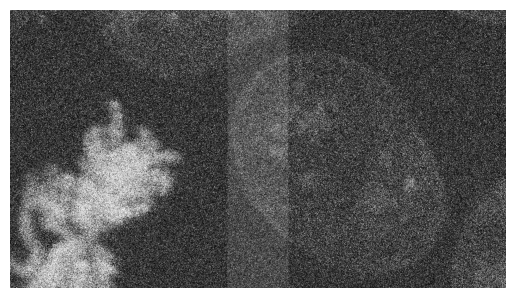

In [3]:
image_map = {'left': left, 'right': right}
image_positions = {'left': (0, 0), 'right': (0, 400)}
output_shape = (512, 912)
stitched_max = hf.simple_stitch(image_map,
                                   image_positions,
                                   (512, 912),
                                   'max')


plt.imshow(stitched_max, cmap='gray'); plt.axis('off'); plt.show()

What if we use an average intensity projection instead? We can do this by fusing tiles with a sum projection and dividing the original stitched image by an array of ones and twos where the pixel value represents the number of images that contributed to that pixel.

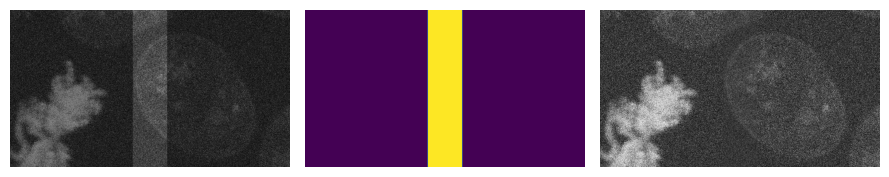

In [8]:
divisor = np.ones(output_shape)
divisor[:, 400:512] = 2
stitched_sum = hf.simple_stitch(image_map,
                                image_positions,
                                (512, 912),
                                'sum')
mean_stitched = stitched_sum / divisor
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
ax1.imshow(stitched_sum, cmap = 'gray'); ax1.axis('off')
ax2.imshow(divisor); ax2.axis('off')
ax3.imshow(mean_stitched, cmap = 'gray'); ax3.axis('off')
fig.tight_layout(); plt.show()

Pretty good! Can we get something even better with linear blending? Here we scale the contribution on each image to the seam as a function of its distance from the edge.

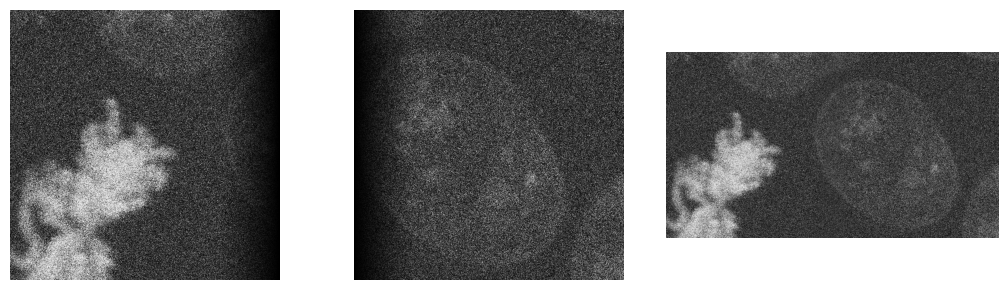

In [5]:
left_gradient = np.tile(np.linspace(1, 0, 112), (512, 1))
right_gradient = np.tile(np.linspace(0, 1, 112), (512, 1))

left_scaled = left.copy()
right_scaled = right.copy()
left_scaled[:, 400:] = left_scaled[:, 400:] * left_gradient
right_scaled[:, :112] = right_scaled[:, :112] * right_gradient
image_map_blending = {'left': left_scaled, 'right': right_scaled}
image_positions_blending = {'left': (0, 0), 'right': (0, 400)}
stitched_blended = hf.simple_stitch(image_map_blending,
                                    image_positions_blending,
                                    (512, 912),
                                    'sum')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10.5,3))
ax1.imshow(left_scaled, cmap='gray'); ax1.axis('off')
ax2.imshow(right_scaled, cmap='gray'); ax2.axis('off')
ax3.imshow(stitched_blended, cmap='gray'); ax3.axis('off')
fig.tight_layout(); plt.show()

Also pretty good! How do these compare to the original max projection?

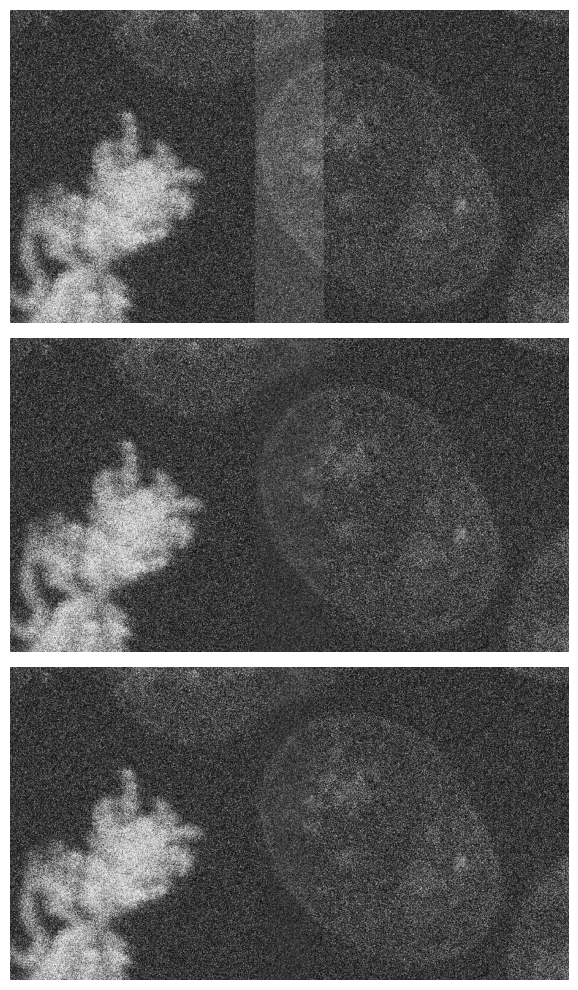

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 10))
ax1.imshow(stitched_max, cmap='gray'); ax1.axis('off')
ax2.imshow(mean_stitched, cmap='gray'); ax2.axis('off')
ax3.imshow(stitched_blended, cmap='gray'); ax3.axis('off')
fig.tight_layout(); plt.show()

It's hard to distinguish between the mean projection and the linear blending. How about if we make a mistake on the stitching registration?

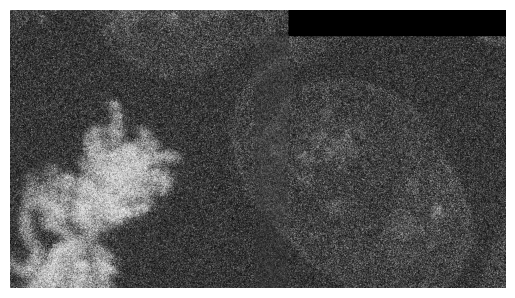

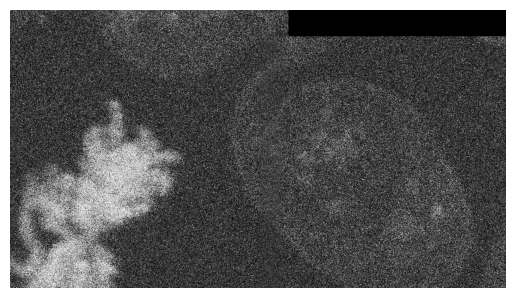

In [7]:
image_positions_offset = {'left': (0, 0), 'right': (50, 450)}
divisor_offset = np.ones(output_shape)
divisor_offset[50:, 450:512] = 2
stitched_sum_offset = hf.simple_stitch(image_map,
                                        image_positions_offset,
                                        (512, 912),
                                        'sum')
mean_stitched_offset = stitched_sum_offset / divisor_offset

left_gradient_offset = np.tile(np.linspace(1, 0, 62), (462, 1))
right_gradient_offset = np.tile(np.linspace(0, 1, 62), (462, 1))

left_scaled_offset = left.copy()
right_scaled_offset = right.copy()
left_scaled_offset[50:, 450:] = left_scaled_offset[50:, 450:] * left_gradient_offset
right_scaled_offset[:512-50, :62] = right_scaled_offset[:512-50, :62] * right_gradient_offset
image_map_blending_offset = {'left': left_scaled_offset, 'right': right_scaled_offset}
stitched_blended = hf.simple_stitch(image_map_blending_offset,
                                    image_positions_offset,
                                    (512, 912),
                                    'sum')

plt.imshow(mean_stitched_offset, cmap = 'gray'); plt.axis('off'); plt.show()
plt.imshow(stitched_blended, cmap = 'gray'); plt.axis('off'); plt.show()

